In [21]:
from qiskit import IBMQ

import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit.circuit.library import IntegerComparator
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import GaussianConditionalIndependenceModel as GCI
from qiskit.providers.ibmq import least_busy
from qiskit import execute, Aer
from qiskit.qasm import pi

import math

from qiskit.primitives import BackendSampler

In [22]:
IBMQ.save_account('327d163f39d663b2ea92fdbd2ffcdfad071e02392bea2944dfee1679b8e14f734e3d9fbcc8d8b18c39990ec47458a2d25e43533a2f979b8c28bedb9e24eed525')

configrc.store_credentials:WARNING:2024-04-14 15:25:46,782: Credentials already present. Set overwrite=True to overwrite.


In [23]:
# 自分のアカウント情報をloadする。（あらかじめ IBMQ.save_account を実行しておく必要がある. 複数のアカウントを使い分ける時はここで行う)
provider = IBMQ.load_account()

# 自分のアカウントで使用できるバックエンドを見る
provider.backends()

ibmqfactory.load_account:WARNING:2024-04-14 15:25:54,987: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_brisbane') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_kyoto') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_osaka') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [24]:
backend_lb = least_busy(provider.backends(simulator=False, operational=True))
print("Least busy backend: ", backend_lb)

#least busyだったbackendを選ぶ
backend_sim = backend_lb

#量子回路qcを指定したバックエンド(backend_sim)で4096回実行する。
#result = execute(qc, backend_sim, shots=4096).result()

#結果を出力する。
#print(result.get_counts(qc))

Least busy backend:  ibm_kyoto


In [25]:
num = 5 #株の数（もしくは変動日数）
theta = math.pi/2 #株の上下変動のしやすさ

In [26]:
qc = QuantumCircuit(num)

for i in range(num):
    qc.ry(theta,i)

qc_measure = qc.measure_all(inplace=False)

qc.draw()

┌─────────┐
q_0: ┤ Ry(π/2) ├
     ├─────────┤
q_1: ┤ Ry(π/2) ├
     ├─────────┤
q_2: ┤ Ry(π/2) ├
     ├─────────┤
q_3: ┤ Ry(π/2) ├
     ├─────────┤
q_4: ┤ Ry(π/2) ├
     └─────────┘

In [27]:
from qiskit.circuit.library import WeightedAdder
from qiskit.circuit.library import LinearAmplitudeFunction

agg = WeightedAdder(num, [10,10,10,10,10])

qr_state = QuantumRegister(qc.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits+1, "carry")
cr = ClassicalRegister(agg.num_sum_qubits, "value")

L_sum_state = QuantumCircuit(qr_state, qr_sum, qr_carry, cr)

# load the variable
L_sum_state.append(qc.to_gate(), qr_state)

# aggregate
L_sum_state.append(agg.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:])

L_sum_state.measure(qr_sum[:],cr[:])

L_sum_state.draw()

┌──────────────┐┌─────────┐                  
state_0: ┤0             ├┤0        ├──────────────────
         │              ││         │                  
state_1: ┤1             ├┤1        ├──────────────────
         │              ││         │                  
state_2: ┤2 circuit-196 ├┤2        ├──────────────────
         │              ││         │                  
state_3: ┤3             ├┤3        ├──────────────────
         │              ││         │                  
state_4: ┤4             ├┤4        ├──────────────────
         └──────────────┘│         │┌─┐               
  sum_0: ────────────────┤5        ├┤M├───────────────
                         │         │└╥┘┌─┐            
  sum_1: ────────────────┤6        ├─╫─┤M├────────────
                         │         │ ║ └╥┘┌─┐         
  sum_2: ────────────────┤7        ├─╫──╫─┤M├─────────
                         │         │ ║  ║ └╥┘┌─┐      
  sum_3: ────────────────┤8  adder ├─╫──╫──╫─┤M├──────
                         │         │ ║  ║  ║ └╥┘┌─┐   
  sum_4: ────────────────┤9        ├─╫──╫──╫──╫─┤M├───
                         │         │ ║  ║  ║  ║ └╥┘┌─┐
  sum_5: ────────────────┤10       ├─╫──╫──╫──╫──╫─┤M├
                         │         │ ║  ║  ║  ║  ║ └╥┘
carry_0: ────────────────┤11       ├─╫──╫──╫──╫──╫──╫─
                         │         │ ║  ║  ║  ║  ║  ║ 
carry_1: ────────────────┤12       ├─╫──╫──╫──╫──╫──╫─
                         │         │ ║  ║  ║  ║  ║  ║ 
carry_2: ────────────────┤13       ├─╫──╫──╫──╫──╫──╫─
                         │         │ ║  ║  ║  ║  ║  ║ 
carry_3: ────────────────┤14       ├─╫──╫──╫──╫──╫──╫─
                         │         │ ║  ║  ║  ║  ║  ║ 
carry_4: ────────────────┤15       ├─╫──╫──╫──╫──╫──╫─
                         │         │ ║  ║  ║  ║  ║  ║ 
carry_5: ────────────────┤16       ├─╫──╫──╫──╫──╫──╫─
                         └─────────┘ ║  ║  ║  ║  ║  ║ 
value: 6/════════════════════════════╩══╩══╩══╩══╩══╩═
                                     0  1  2  3  4  5

In [29]:
sampler = BackendSampler(backend=backend_sim)
job = sampler.run(L_sum_state)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [30]:
qubit_state_L = []

for i, prob in binary_probabilities.items():
    print(i,prob)
    qubit_state_L.append([i,prob])

qubit_state_L.sort()

111010 0.03075
011010 0.033
010011 0.00025
011001 0.001
101001 0.001
010100 0.03125
100000 0.0275
010110 0.0245
010010 0.032
101100 0.03
100010 0.02875
111100 0.02725
010001 0.0005
111001 0.0005
011101 0.00075
010111 0.0005
011100 0.03
101010 0.033
000000 0.0355
011111 0.0005
110000 0.037
110100 0.02875
000111 0.00075
100110 0.0255
001000 0.02875
011000 0.03325
001100 0.0295
010101 0.0005
111011 0.00075
011110 0.032
100001 0.00025
000011 0.00025
101000 0.032
101011 0.00075
100101 0.00075
110010 0.03425
001010 0.03425
000100 0.029
010000 0.031
100100 0.02475
001001 0.001
111000 0.03175
001101 0.00075
111101 0.001
110110 0.031
111111 0.00075
110111 0.001
000010 0.031
001110 0.031
111110 0.03
100111 0.0005
110101 0.0005
110001 0.00125
000001 0.0005
100011 0.0005
000110 0.03125
001011 0.00025
000101 0.0005
101110 0.0315
011011 0.00025
110011 0.00125


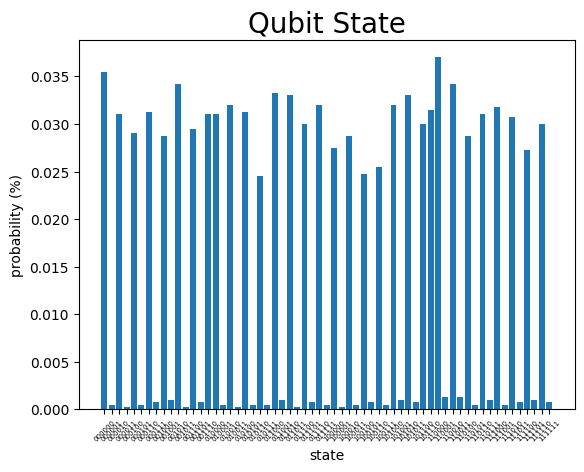

In [31]:
# plot probabilities of each states
q_state_L = []
q_prob_L = []
for state in qubit_state_L:
    q_state_L.append(state[0])
    q_prob_L.append(state[1])

plt.bar(q_state_L,q_prob_L)
#plt.legend(fontsize=15)
plt.xlabel("state", size=10)
plt.ylabel("probability (%)", size=10)
plt.title("Qubit State", size=20)
plt.xticks(size=5,rotation=45)
plt.yticks(size=10)
plt.show()